# Xin Jin and Xuan guo's Project Report 

### Project goal
Our Project focus on EM algorithm to identify the unusual users in the Netflix data set. After elimate these users. We can have a better result in recommendation the movies

### Introduction of EM algorithm
The Expectation-Maximization (EM) algorithm is a way to find maximum-likelihood estimates for model parameters when your data is incomplete, has missing data points, or has unobserved (hidden) latent variables. It is an iterative way to approximate the maximum likelihood function. While maximum likelihood estimation can find the “best fit” model for a set of data, it doesn’t work particularly well for incomplete data sets. The more complex EM algorithm can find model parameters even if you have missing data. It works by choosing random values for the missing data points, and using those guesses to estimate a second set of data. The new values are used to create a better guess for the first set, and the process continues until the algorithm converges on a fixed point.



### First part: Clean the dataset and prepare for the EM algorithm


#### 1.Import the package we will use 

In [1]:
import pandas as pd #handle data
import numpy as np
import math
import matplotlib.pyplot as plt 
import re #regular expression
from scipy.sparse import csr_matrix #Compressed Sparse Row matrix
import matplotlib.pyplot as plt
import seaborn as sns # plot package related to statistics
#package related to recommend system
from surprise import Reader, Dataset, SVD, evaluate 
from surprise.model_selection import cross_validate

#### 2.Load the dataset

In [2]:
df = pd.read_csv('D:\TAMU\courses\stat 689 Statistical Computing with R and Python,\project/combined_data_1.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])
df['Rating'] = df['Rating'].astype(float)


#### 3.Here we roughly look at the size of the dataset

In [3]:
print('Dataset 1 shape: {}'.format(df.shape))
print('-Dataset examples-')
print(df.iloc[::5000000, :])

Dataset 1 shape: (24058263, 2)
-Dataset examples-
          Cust_Id  Rating
0              1:     NaN
5000000   2560324     4.0
10000000  2271935     2.0
15000000  1921803     2.0
20000000  1933327     3.0


From the above output, we can see there are 24 million rating in this dataset, it is very big! And we see that the there is a movie id in the first row, then followed by rating, after the rating about movie 1, then there's movie 2 in a row and then ratings. We cannot keep the data set like this, I think we should try to keep the user id in a new col, then it will be possible for us to handle the dataset

#### 4.Here we start wo do data cleaning

In [4]:
df_nan = pd.DataFrame(pd.isnull(df.Rating)) #find the rating which is null
df_nan = df_nan[df_nan["Rating"]==True] # reduce the matrix, only show the rows with null
df_nan = df_nan.reset_index()
movie_np = []
movie_id = 1



Here we create a dataframe to find the movie id row. We will keep these movie id in a list and then put the movie id in the third column of the dataframe.

In [5]:
for i,j in zip(df_nan["index"][1:],df_nan["index"][:-1]):
    temp = np.full((1,i-j-1),movie_id) #create a constant array, the constant is the movie id
    movie_np = np.append(movie_np,temp)
    movie_id += 1


We keep the movie Id in a list

In [6]:
last_record = np.full((1,len(df)-df_nan.iloc[-1,0]-1),movie_id)
movie_np = np.append(movie_np,last_record)

print('Movie numpy: {}'.format(movie_np))
print('Length: {}'.format(len(movie_np)))

Movie numpy: [  1.00000000e+00   1.00000000e+00   1.00000000e+00 ...,   4.49900000e+03
   4.49900000e+03   4.49900000e+03]
Length: 24053764


We get the movie list above, the last one should be added. We print the length to be convinient to debug, if the length is not match the rest rows, then we can easily look at the length.

In [7]:
df = df[pd.notnull(df['Rating'])]

df['Movie_Id'] = movie_np.astype(int)
df['Cust_Id'] = df['Cust_Id'].astype(int)
print('-Dataset examples-')
print(df.iloc[::5000000, :])

-Dataset examples-
          Cust_Id  Rating  Movie_Id
1         1488844     3.0         1
5000996    501954     2.0       996
10001962   404654     5.0      1962
15002876   886608     2.0      2876
20003825  1193835     2.0      3825


We add the movie id to the third column and we show how the dataframe like now. The dataframe is what we want. After we get this dataset, we can begin to handle the dataset.

#### 5.Data slicing

The data set is too big and we really have problems in memory if we handle the whole dataset, so we decide to reduce the dataset. For the movies with a few ratings and the users who only rates a few movies, they won't do too much help for the recommendation, sometimes they even reduce the reliability of the recommendation system. So we decide to only keep the movies and users who has a lot of ratings.

In [8]:
f = ["count","mean"]
df_movie_summary = df.groupby("Movie_Id")["Rating"].agg(f) #get the mean rating of movie and the rating quantity
df_movie_summary.index = df_movie_summary.index.map(int)
# drop the movies with small numbers of rating quantity
movie_benchmark = round(df_movie_summary['count'].quantile(0.8),0)
drop_movie_list = df_movie_summary[df_movie_summary['count'] < movie_benchmark].index 
print('Movie minimum times of review: {}'.format(movie_benchmark))

Movie minimum times of review: 3884.0


We keep the movie with more than 3884 reviews

In [9]:
df_cust_summary = df.groupby('Cust_Id')['Rating'].agg(f)
df_cust_summary.index = df_cust_summary.index.map(int)
cust_benchmark = round(df_cust_summary['count'].quantile(0.8),0)
drop_cust_list = df_cust_summary[df_cust_summary['count'] < cust_benchmark].index

print('Customer minimum times of review: {}'.format(cust_benchmark))

Customer minimum times of review: 79.0


We keep the user with more than 79 reviews

In [10]:
print('Original Shape: {}'.format(df.shape))
df = df[~df['Movie_Id'].isin(drop_movie_list)]
df = df[~df['Cust_Id'].isin(drop_cust_list)]
print('After Trim Shape: {}'.format(df.shape))
print('-Data Examples-')
print(df.iloc[::5000000, :])

Original Shape: (24053764, 3)
After Trim Shape: (13528427, 3)
-Data Examples-
          Cust_Id  Rating  Movie_Id
5109       785314     1.0         8
8889698    332300     3.0      1770
17751978   629874     4.0      3391


From above, after removing those specific movies and users, we still have 13 million data

In [11]:
df_p = pd.pivot_table(df,values='Rating',index='Cust_Id',columns='Movie_Id')

print(df_p.shape)

(95325, 900)


We have 95325 users and 900 movies

In [12]:
print(df)

          Cust_Id  Rating  Movie_Id
5109       785314     1.0         8
5110       243963     3.0         8
5112      1447783     4.0         8
5116      1912665     1.0         8
5119      1744889     1.0         8
5122      2289614     3.0         8
5125      2460625     3.0         8
5127      2330282     4.0         8
5128      2098867     4.0         8
5129      1395430     2.0         8
5131        56069     5.0         8
5134      1571931     3.0         8
5141      1833399     3.0         8
5144        66358     3.0         8
5145       512852     3.0         8
5146      1191521     4.0         8
5147       439011     4.0         8
5154      1205593     4.0         8
5155       176006     1.0         8
5157      1488844     4.0         8
5158      1947516     1.0         8
5160      1320901     4.0         8
5168       802657     5.0         8
5169      2312677     3.0         8
5172      1829027     5.0         8
5173        44317     4.0         8
5174      1447354     1.0   

This is a brief look of the dataframe, the movie Id and Customer Id is a mess, in order to handle and view the data set easily, I will change the customer id into 1-95325 and movie id into 1-900.

In [13]:
print(df_p)

Movie_Id  8     17    18    26    28    30    33    44    46    52    ...   \
Cust_Id                                                               ...    
6          NaN   NaN   NaN   NaN   NaN   3.0   NaN   NaN   NaN   NaN  ...    
7          5.0   NaN   NaN   NaN   4.0   5.0   NaN   NaN   NaN   NaN  ...    
79         NaN   NaN   NaN   NaN   NaN   3.0   NaN   NaN   NaN   NaN  ...    
97         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...    
134        NaN   NaN   NaN   NaN   5.0   NaN   NaN   NaN   NaN   NaN  ...    
188        NaN   NaN   NaN   NaN   NaN   3.0   NaN   NaN   NaN   NaN  ...    
195        NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...    
199        NaN   NaN   NaN   NaN   NaN   5.0   NaN   NaN   NaN   NaN  ...    
201        NaN   NaN   NaN   NaN   4.0   5.0   NaN   NaN   NaN   NaN  ...    
265        NaN   NaN   NaN   NaN   3.0   5.0   NaN   NaN   NaN   NaN  ...    
283        NaN   NaN   NaN   NaN   NaN   4.0   NaN   NaN   NaN  

This is the pivot table

#### 6.Change the Id into a better form

In [12]:
movie_id_1 = []
for i in df['Movie_Id']:
    movie_id_1.append(i)

store the movie id in a list

In [13]:
movie_id_2 = set(movie_id_1)
movie_id_2 = list(movie_id_2)
print(len(movie_id_1))
print(len(movie_id_2))

13528427
900


In [14]:
movie_dic ={}
j = 1
for i in range(len(movie_id_1)-1):
    if movie_id_1[i] == movie_id_1[i+1] and movie_id_1[i] not in movie_dic.keys():
        movie_dic[movie_id_1[i]] = j
    elif movie_id_1[i] != movie_id_1[i+1] :
        j += 1

Create a dictionary to change the original customer id in to 1,2,3....95325

In [15]:
movie_new = []
for i in movie_id_1:
    movie_new.append(movie_dic[i])

Get the new movie id list

In [16]:
df2 = df
df2 = df2.sort_values(by ="Cust_Id")

In [19]:
print (df2)

          Cust_Id  Rating  Movie_Id
19883587        6     2.0      3798
21919658        6     4.0      4127
11625971        6     3.0      2200
9275314         6     3.0      1832
21537115        6     5.0      4043
881822          6     3.0       197
7693939         6     3.0      1542
17390462        6     4.0      3333
9157986         6     3.0      1803
10342769        6     4.0      2001
15390152        6     4.0      2953
6774976         6     3.0      1314
16312184        6     1.0      3151
18514848        6     3.0      3538
17269698        6     3.0      3320
2357555         6     3.0       445
18792200        6     4.0      3608
9916054         6     4.0      1918
23530651        6     3.0      4393
13897038        6     3.0      2660
19720401        6     3.0      3756
7802129         6     3.0      1561
4928285         6     4.0       985
23774363        6     3.0      4432
9843632         6     4.0      1905
19952991        6     2.0      3817
20290505        6     3.0   

sort by th customer id

In [17]:
cust_id_1 = []
for i in df2['Cust_Id']:
    cust_id_1.append(i)
cust_id_2 = set(cust_id_1)
cust_id_2 = list(cust_id_2)
print (len(cust_id_1))
print (len(cust_id_2))



13528427
95325


In [18]:
cust_dic ={}
j = 1
for i in range(len(cust_id_1)-1):
    if cust_id_1[i] == cust_id_1[i+1] and cust_id_1[i] not in cust_dic.keys():
        cust_dic[cust_id_1[i]] = j
    elif cust_id_1[i] != cust_id_1[i+1] :
        j += 1

Create a dictionary to change the original movie id in to 1,2,3....900

In [19]:
cust_id_0 = []
for i in df['Cust_Id']:
    cust_id_0.append(i)

In [20]:
cust_new = []
for i in cust_id_0:
    cust_new.append(cust_dic[i])

Get the new customer id list

In [21]:
df_new =df
df_new["Movie_Id"] = movie_new
df_new["Cust_Id"] = cust_new

In [25]:
print(df_new)

          Cust_Id  Rating  Movie_Id
5109        28573     1.0         1
5110         8760     3.0         1
5112        52383     4.0         1
5116        69101     1.0         1
5119        63095     1.0         1
5122        82437     3.0         1
5125        88553     3.0         1
5127        83859     4.0         1
5128        75699     4.0         1
5129        50558     2.0         1
5131         2017     5.0         1
5134        56995     3.0         1
5141        66332     3.0         1
5144         2355     3.0         1
5145        18690     3.0         1
5146        43233     4.0         1
5147        15979     4.0         1
5154        43707     4.0         1
5155         6291     1.0         1
5157        53916     4.0         1
5158        70345     1.0         1
5160        47942     4.0         1
5168        29179     5.0         1
5169        83261     3.0         1
5172        66195     5.0         1
5173         1609     4.0         1
5174        52369     1.0   

This is the new dataframe we get, everything looks much better!

In [22]:
df_new_2 = df_new
df_new_2 = df_new_2.sort_values(by =["Cust_Id","Movie_Id"])

In [27]:
print(df_new_2)

          Cust_Id  Rating  Movie_Id
187327          1     3.0         6
649807          1     5.0        28
795633          1     2.0        31
881822          1     3.0        32
1054025         1     3.0        41
1368727         1     4.0        58
1438678         1     3.0        59
1723707         1     4.0        64
2020328         1     3.0        73
2357555         1     3.0        93
2462409         1     5.0        94
2547684         1     3.0        96
2785647         1     3.0       103
2811338         1     3.0       105
2886520         1     4.0       109
3005956         1     4.0       118
3183390         1     3.0       121
3452557         1     3.0       133
3658381         1     3.0       148
3807435         1     3.0       153
4100524         1     3.0       164
4300063         1     3.0       172
4460694         1     3.0       180
4564709         1     5.0       182
4928285         1     4.0       197
5366935         1     3.0       221
5710285         1     2.0   

This is sorted by customer id and movie id. Customer id is the first sort element.

In [23]:
df_new_3 = df_new
df_new_3 = df_new_3.sort_values(by =["Movie_Id","Cust_Id"])

In [29]:
print(df_new_3)

          Cust_Id  Rating  Movie_Id
12549           2     5.0         1
8718           23     1.0         1
5549           39     3.0         1
7297           77     2.0         1
13595         108     2.0         1
8909          110     4.0         1
12985         111     1.0         1
18995         113     2.0         1
12810         121     3.0         1
12834         151     3.0         1
19068         159     5.0         1
8807          161     5.0         1
10803         163     2.0         1
14356         178     3.0         1
15514         192     3.0         1
16286         204     5.0         1
8857          234     1.0         1
7418          239     5.0         1
15425         263     4.0         1
19625         267     3.0         1
6532          268     4.0         1
8084          275     1.0         1
12309         308     3.0         1
14294         312     2.0         1
7562          325     3.0         1
7797          357     1.0         1
5991          377     3.0   

This is sorted by customer id and movie id. Movie id is the first sort element.

#### 7.Store the rating in a list

In [24]:
cust_new_order = list(cust_new)
cust_new_order = sorted(cust_new_order)

In [25]:
rating_1 = []
for i in df_new_2['Rating']:
    rating_1.append(i)

Store the rating in a list

In [26]:
movie_new_1 = []
for i in df_new_2['Movie_Id']:
    movie_new_1.append(i)

In [27]:
x = []# the rating user gives to movie
w = []
i = 0
j = 0
x0 = 1
y0 = 1
temp1 = []
temp2 = []
while i < len(cust_new_order) and j <len(movie_new_1):
    
    if i ==len(cust_new_order)-1:
        while len(temp1)<900:
            temp1.append(-1)
            temp2.append(-1)
        x.append(temp1)
        w.append(temp2)
        i += 1
        
    
    elif cust_new_order[i] == x0 and movie_new_1[j] == y0:
        temp1.append(rating_1[i])
        temp2.append(1)
        i += 1
        j += 1
        y0 += 1
    elif cust_new_order[i] == x0 and movie_new_1[j] != y0:
        temp1.append(-1)
        temp2.append(-2)
        y0 += 1
    elif cust_new_order[i] != x0:
        while len(temp1)<900:
            temp1.append(-1)
            temp2.append(-1)
        x.append(temp1)
        w.append(temp2)
        x0 += 1
        y0 = 1
        temp1 = []
        temp2 = []


Store the rating in a two demension list, just like matrix, x[0] is a list about user 1, x[0][0] is the rating user 1 gives to movie1 , if user 1 didn't rate movie 1, then it equals -1, which means not applicable.

Here I also create a two demension list the same as x, here we call it w, I will use this in the next EM algorithm part.

### Second part: Implement the EM algorithm

#### 1.Introduce the model

Each rater does so in one of two modes that we will call “quirky” and “consensus.” In quirky mode, rater i has a private rating distribution with probability mass function $ q(x|\alpha_i)$ that applies to every movie regardless of its intrinsic merit. In consensus mode, rater i rates movie j according to a distribution with probability mass function $c(x|\beta_j)$ shared with all other raters in consensus mode. For every movie i rates, he or she makes a quirky decision with probability $\pi_i$and a consensus decision with probability 1 − $\pi_i$. These decisions are made independently across raters and movies. If $x_{ij}$ is the rating given to movie j by rater i, the log likelihood of the data is

Formula 1:$$ log(L(\theta)) =\sum_i\sum_{j_{x_{ij}>0}} log[\pi_i*q(x_{ij}|\alpha_i)+(1-\pi_i)*c(x_{ij}|\beta_j)] $$

In our model, we want to find the user with a high $\pi$. We identify these users unusual users, our goal of the EM algorithm is to find these users. We update each parameter in every step. After some steps, we will get a resonable $\pi$

In our model, we use the binomial mode for q and c. k is the rating, d equals 5 here

Formula 2:$$ q(k|\alpha_i) = \begin{pmatrix}d-1\\k-1\end{pmatrix}*\alpha_i^{k-1}*(1-\alpha_i)^{d-k}$$
Formula 3:$$ c(k|\beta_j) = \begin{pmatrix}d-1\\k-1\end{pmatrix}*\beta_j^{k-1}*(1-\beta_j)^{d-k}$$

We define $w_{ij}$, n means the value in nth step:

Formula 4:$$w_{ij}^{n} =\frac{\pi_i^{n}*q(x_{ij}|\alpha_i^{n})}{\pi_i^{n}*q(x_{ij}|\alpha_i^{n}) + (1-\pi_i^{n})*c(x_{ij}|\beta_j^{n})} $$

The formula 4 above is our expectation step, also called the E step.

Formula 5: $$\pi_i^{n+1} = \frac{\sum_{j_{x_{ij}>0}}w_{ij}^{n}}{m_i}$$

Formula 6: $$ \alpha_i^{n+1} = \frac{\sum_{j_{x_{ij}>0}}w_{ij}^{n}*(x_{ij}-1)}{(d-1)*\sum_{j_{x_{ij}>0}}w_{ij}^{n}} $$

Formula 7: $$ \beta_j^{n+1} = \frac{\sum_i(1-w_{ij}^{n})*(x_{ij}-1)}{(d-1)*\sum_i(1-w_{ij}^{n})} $$

The three formulas above are the M step, we update the parameters in order to get to maximize the log likelihood function. The $m_i$ in formula 5 is the number of movies user i have rated.

#### 2.Implement the model

In [28]:
def pri_dist(alpha,rating):
    ans = alpha**(rating-1)*(1-alpha)**(5-rating)*24/(math.factorial(int(rating-1))*math.factorial(int(5-rating)))
    return ans

This corresponds to formula 2

In [29]:
def con_dist(beta,rating):
    ans = beta**(rating-1)*(1-beta)**(5-rating)*24/(math.factorial(int(rating-1))*math.factorial(int(5-rating)))
    return ans

This corresponds to formula 3

In [30]:
def loglikeli(pi,alpha,beta,x):
    s = 0
    for user in range(len(x)):
        for mov in range(len(x[user])):
            if x[user][mov] > 0:
                a = pi[user]*pri_dist(alpha[user],x[user][mov])
                b = (1-pi[user])*con_dist(beta[mov],x[user][mov])
                s += math.log(a+b)
    return s

This corresponds to formula 1

In [31]:
def get_w(pi,alpha,beta,x,w):
    for user in range(len(w)):
        for mov in range(len(w[user])):
            if w[user][mov]>0:
                a = pi[user]*pri_dist(alpha[user],x[user][mov])
                b = a + (1-pi[user])*con_dist(beta[mov],x[user][mov])
                w[user][mov]= a/b
    return w

This corresponds to formula 4

In [32]:
def get_pi(pi,w):
    pi2 = list(pi)
    for user in range(len(pi)):
        s = 0
        n = 0
        for movie in w[user]:
            if movie>0:
                s += movie
                n += 1
        pi2[user] = s/n
    return pi2

This corresponds to formula 5

In [33]:
def get_alpha(x,w):
    alpha = []
    for user in range(len(x)):
        a = 0
        b = 0
        for mov in range(len(x[0])):
            if w[user][mov]>0:
                a += w[user][mov]*(x[user][mov]-1)
                b += w[user][mov]
        alpha.append(a/(b*4))
    return alpha
            

This corresponds to formula 6

In [34]:
def get_beta(x,w):
    beta = []
    for mov in range(len(x[0])):
        a = 0
        b = 0
        for user in range(len(x)):
            if x[user][mov] > 0:
                a += (1-w[user][mov])*(x[user][mov]-1)
                b += 4*(1-w[user][mov])
        beta.append(a/b)
    return beta
                

This corresponds to formula 7

In [35]:
pi = []
for i in range(len(cust_id_2)):
    pi.append(0.2)

Give some initial value to $\pi$

In [36]:
alpha = []
for i in range(len(cust_id_2)):
    alpha.append(0.2)

Give some initial value to $\alpha$

In [37]:
beta = []
for i in range(len(movie_id_2)):
    beta.append(0.2)

Give some initial value to $\beta$

In [38]:
l1 = loglikeli(pi,alpha,beta,x)
l1

-44750813.9306213

Calculate the loglikelihood for the initial values.

In [39]:
l = [l1]

In [44]:
c = 0
while c<20:
    w = get_w(pi,alpha,beta,x,w)
    pi = get_pi(pi,w)
    alpha = get_alpha(x,w)
    beta = get_beta(x,w)
    like = loglikeli(pi,alpha,beta,x)
    if ((l[-1]-like)/l[-1])<0.0005:
        break
        
    l.append(like)
    c += 1

Here is the EM algorithm, it is quite straight forward. If the new loglikelihood doesn't improve more than 0.05%, we break the loop, it costs  a lot of time here, so if we want to a better precision, maybe I need to buy a better computer.  

In [41]:
l

[-44750813.9306213,
 -17953815.863757826,
 -17480821.25479855,
 -17283017.47249343,
 -17201467.36237369,
 -17156534.31583064,
 -17125683.394965343,
 -17102350.607154228,
 -17083922.86357335,
 -17069056.081922524,
 -17057069.78541323,
 -17047400.61556667]

This is the loglikelihood in each step, we improve a lot in first step because the initial values are far away from the convergence values. And we see the loglikehood becomes bigger in each step, which means our algorithm is right. The basic goal of EM algorithm is to maximize the likelihood function.

In [55]:
for i in range(len(pi)):
    if pi[i] >0.99:
        print(i)

644
986
1118
1363
3058
3804
3847
4623
5043
6258
6455
6959
7463
7780
8015
8068
8385
9256
10227
10661
10870
10873
11288
11326
12161
12663
13293
14450
14573
15202
17029
17399
18566
19202
19318
19354
20169
20954
21094
21624
22681
22892
22906
23148
23295
23426
23731
25333
25552
26262
27398
27719
28555
28919
30574
31188
31490
31561
31590
33378
35026
35897
36063
36410
36659
38726
39300
42229
42265
42795
42833
43299
44453
44660
45826
46124
46146
47516
48043
48755
49177
50166
50715
50737
50738
50776
51221
51915
52959
53096
53191
53512
53697
53896
54664
54784
55122
55386
57670
58183
58885
59712
59736
60161
60168
62648
62840
63123
63693
64781
65085
65336
66386
66408
67253
67257
67393
67527
68227
69194
69540
69633
70343
70503
72955
73351
74299
74399
74628
75766
77395
78034
78231
79328
80108
80397
80474
80705
80774
82077
82123
82260
82975
83066
83114
83555
83580
83706
84769
85985
87751
88088
88199
88366
88787
89003
90561
91285
91346
92130
92585
93200
94366
94739
94835
95012


To check that our algorithm is right, we get some users with a extremely high $\pi$. Bigger than 0.99!

In [58]:
df_986 = df_new[(df_new['Cust_Id'] == 987)]
print(df_986)

          Cust_Id  Rating  Movie_Id
72263         987     5.0         5
297076        987     5.0        12
306284        987     5.0        13
709595        987     5.0        30
766008        987     5.0        31
954652        987     5.0        35
1359964       987     5.0        58
1465411       987     5.0        60
1703757       987     5.0        64
2075909       987     5.0        78
2227005       987     5.0        85
2256753       987     5.0        89
2427293       987     5.0        94
2529331       987     5.0        96
2577111       987     5.0        98
2701185       987     5.0       100
2964736       987     5.0       115
2991881       987     5.0       117
3002682       987     5.0       118
3266212       987     5.0       123
3544877       987     5.0       141
3560320       987     5.0       143
3624369       987     5.0       147
3646742       987     5.0       148
4082886       987     5.0       164
4282232       987     5.0       171
4383257       987     5.0   

We get the rating for user 987, we can see that this user always gives 5. This is the unusual user we want to find. It seems that our algorithm did the things we expect.

In [53]:
quirky =[]
for i in range(len(pi)):
    if pi[i] >0.6:
        quirky.append(i)

Here we define the users with $\pi$ bigger than 0.6 as unusual users

In [54]:
len(quirky)

7266

We will remove these 7266 users

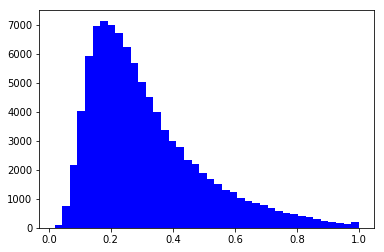

In [54]:
fig = plt.figure()
ax = plt.axes()
n, bins, rectangles = ax.hist(pi,40,color='blue')
plt.show()

This is the hist of $\pi$ we get

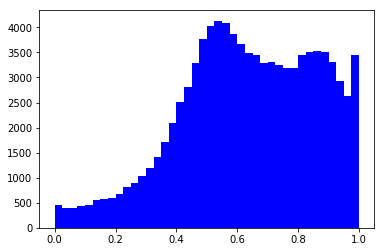

In [42]:
fig = plt.figure()
ax = plt.axes()
n, bins, rectangles = ax.hist(alpha,40,color='blue')
plt.show()

This is the hist of $\alpha$ we get

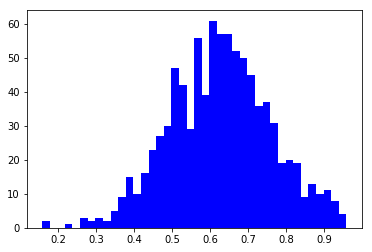

In [43]:
fig = plt.figure()
ax = plt.axes()
n, bins, rectangles = ax.hist(beta,40,color='blue')
plt.show()

This is the hist of $\beta$ we get

### Third part: Compare the original collaborate filtering result and the result after remove some unusual users

In [50]:
reader = Reader()


data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']][:2000000], reader)
data.split(n_folds=5)

svd = SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'])

{'fit_time': (141.32738661766052,
  151.54900240898132,
  144.72917556762695,
  140.99976992607117,
  126.83862566947937),
 'test_mae': array([ 0.73327766,  0.73297882,  0.73231072,  0.73095701,  0.73001626]),
 'test_rmse': array([ 0.93505776,  0.93468037,  0.93444277,  0.93125733,  0.92982399]),
 'test_time': (5.796457290649414,
  5.096686124801636,
  4.8470094203948975,
  4.365606069564819,
  3.231356620788574)}

Here is the result of use collaborate filtering from the original dataset. Here we just use the first 2 million rating because it takes too much time to use the whold dataset.

In [55]:
drop_list = df_new[df_new['Cust_Id'] ==quirky[0]]

In [56]:
for i in quirky[1:]:
    
    drop_list = drop_list.append(df_new[df_new['Cust_Id']==i])

In [57]:
df_after_EM = df_new[~df_new["Cust_Id"].isin(quirky)]

Here we get the dataset after remove unusual users

In [58]:
print('After Trim Shape: {}'.format(df_after_EM.shape))

After Trim Shape: (12494788, 3)


In [59]:
reader = Reader()


data = Dataset.load_from_df(df_after_EM[['Cust_Id', 'Movie_Id', 'Rating']][:2000000], reader)
data.split(n_folds=5)

svd = SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'])

{'fit_time': (137.04932761192322,
  135.42327165603638,
  136.73688554763794,
  132.8835961818695,
  128.66199922561646),
 'test_mae': array([ 0.72625528,  0.7286607 ,  0.72662997,  0.72764525,  0.72870872]),
 'test_rmse': array([ 0.92592605,  0.92794139,  0.9263454 ,  0.92663783,  0.9272608 ]),
 'test_time': (5.845985651016235,
  4.9272801876068115,
  4.120047330856323,
  3.219062089920044,
  3.083280563354492)}

The above is the result after removing the unusual users. Compare to the first result, we see the mae and rmse is significantly smaller than the first model. Which means the second model is better in recommend, these unusual users did bad effect in the recommendation system. Our project is successful!

### Fourth part: Conclusions and further discuss

#### 1. Conclusion

From the results we get in the third part, we can say our project is successful. The EM algorithm helps us to calculate the $\pi$ of each user, and we use the $\pi$ to find the unusual users in the dataset. After we remove these users, our recommendation system becomes better!

#### 2. Discuss

Although our project has a good result, we can also do some improvement in the future. 

First, we didn't do many EM steps, if we use a better computer, we can do more steps and get the accurate results. 

Second, in our assumption, we use the binomial model to simulate the private and consensus model. We can build more other models and compare these models to find the best model.

In the future, we would like to apply this EM method to other dataset other than this.